In [71]:
import importlib

import dataset, metrics, plotting, config, network
from models import reg_cgan_model
import numpy as np
import random

importlib.reload(network)
importlib.reload(dataset)
importlib.reload(metrics)
importlib.reload(plotting)
importlib.reload(config)
importlib.reload(reg_cgan_model)

<module 'models.reg_cgan_model' from '/Users/zhongsheng/Documents/GitWorkspace/RegCGAN/models/reg_cgan_model.py'>

In [2]:
import os

dataset_config = config.DatasetConfig(scenario="hdpeuce")

assert(dataset_config.scenario == "magical_sinus"
      or dataset_config.scenario == "hdpeuce")
fig_dir = f"../figures/{dataset_config.scenario}"

try:
    os.mkdir(fig_dir)
    print(f"Directory {fig_dir} created ")
except FileExistsError:
    print(f"Directory {fig_dir} already exists replacing files in this notebook")

Directory ../figures/hdpeuce already exists replacing files in this notebook


In [3]:
exp_config = config.Config(
    model=config.ModelConfig(activation="elu", lr_gen=0.0001, lr_disc=0.0001,
                             optim_gen="Adam", optim_disc="Adam", z_input_size=5),
    training=config.TrainingConfig(n_epochs=10000, batch_size=100, n_sampling=200),
    dataset=dataset_config,
    run=config.RunConfig(save_fig=1)
)

In [4]:
# Set random seed
np.random.seed(exp_config.model.random_seed)
random.seed(exp_config.model.random_seed)

from tensorflow import set_random_seed
set_random_seed(exp_config.model.random_seed)

In [9]:
X_train, y_train, X_valid, y_valid = dataset.get_dataset(scenario=exp_config.dataset.scenario,
                                                                         seed=exp_config.model.random_seed)

In [10]:

from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)

## Finding sparse regions using Local Outlier Factor (LOF)

In [11]:
from sklearn.neighbors import LocalOutlierFactor


X = X_train_scaled
clf = LocalOutlierFactor(n_neighbors=40)
clf.fit(X)
X_scores = clf.negative_outlier_factor_
mean_scores = np.mean(X_scores)
mask = X_scores > mean_scores

X_outliers = X[mask]

## CVT sampling and discrepancy evaluating

In [ ]:
from idaes.surrogate.pysmo import sampling as sp
import matplotlib.pyplot as plt
from diversipy import unanchored_L2_discrepancy

assert len(X_outliers) !=0, "No sparse regions in the input space has been found."

min_n_sampling, max_n_sampling, interval = 60, 500, 60

minimum, maximum = np.amin(X_outliers, axis=0).tolist(), np.amax(X_outliers, axis=0).tolist()
bounds = [minimum, maximum]

X_discrepancy = unanchored_L2_discrepancy(X_outliers)
X_CVT_discrepancy_list, X_full_discrepancy_list, CVT_dict = [], [], {}
i = 0
for n_sampling in range(min_n_sampling, max_n_sampling, interval):
    space_init = sp.CVTSampling(bounds, sampling_type="creation", number_of_samples=n_sampling)
    X_CVT = space_init.sample_points()
    CVT_dict[f"num_sampling_{n_sampling}"] = X_CVT
    X_CVT_discrepancy = unanchored_L2_discrepancy(X_CVT)
    X_CVT_discrepancy_list.append(X_CVT_discrepancy)

    X_full = np.r_[X, X_CVT]
    X_full_discrepancy = unanchored_L2_discrepancy(X_full)
    X_full_discrepancy_list.append(X_full_discrepancy)
    print(f"Discrepancy values: {X_discrepancy:.2e} for original data; "
          f"{X_CVT_discrepancy:.2e} for {n_sampling} CVT samples; "
          f"{X_full_discrepancy:.2e} for full data.")

best_n_sampling = np.arange(min_n_sampling, max_n_sampling, interval)[np.argmin(np.array(X_full_discrepancy_list))]
best_CVT = CVT_dict[f"num_sampling_{best_n_sampling}"]
print(f"The  optimal value for n_sampling in CVT sampling is {best_n_sampling}")

In [ ]:
X_discrepancy = unanchored_L2_discrepancy(X_outliers)
plotting.plot_cvt_discrepancy(min_n_sampling, max_n_sampling, interval,
                              X_full_discrepancy_list, fig_dir,
                              title=f"Discrepancy baseline = {X_discrepancy:2.2e}")

In [ ]:
from scipy.spatial import Voronoi
from scipy.spatial import voronoi_plot_2d

sampling_key = f"num_sampling_{best_n_sampling}"
X_CVT = CVT_dict[sampling_key]

# save CVT samples to .npy file
from os.path import basename
np.save(f"{fig_dir}/{basename(fig_dir)}_cvt_samples.npy", X_scaler.inverse_transform(X_CVT))

In [20]:
from os.path import basename
X_CVT = np.load(f"{fig_dir}/{basename(fig_dir)}_cvt_samples.npy")

from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_valid_scaled = X_scaler.transform(X_valid)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_valid_scaled = y_scaler.transform(y_valid.reshape(-1, 1))

## Gaussian Process

In [218]:
import GPy


variance = 4.5
length = 1.5

kernel = GPy.kern.RBF(input_dim=15, variance=variance, lengthscale=length)
gpr = GPy.models.GPRegression(X_train_scaled, y_train_scaled, kernel)

run_hyperopt_search = False
if run_hyperopt_search:
    gpr.optimize(messages=True)
ypred_gp_val, cov = gpr.predict(X_valid_scaled)

##  construct RegCGAN

In [ ]:
regcgan = reg_cgan_model.RegCGAN(exp_config)
d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true = regcgan.train(X_train_scaled, y_train_scaled,
                                                                              epochs=exp_config.training.n_epochs,
                                                                              batch_size=exp_config.training.batch_size,
                                                                              verbose=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Generator_input_x (InputLayer)  (None, 15)           0                                            
__________________________________________________________________________________________________
Generator_input_z (InputLayer)  (None, 5)            0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 60)           960         Generator_input_x[0][0]          
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 60)           360         Generator_input_z[0][0]          
__________________________________________________________________________________________________
concatenat

 /Users/zhongsheng/anaconda2/envs/Reg-CGAN/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Epoch: 0 / dLoss: 1.4661753177642822 / gLoss: 0.6579635143280029
Epoch: 1 / dLoss: 1.4239213466644287 / gLoss: 0.646635115146637
Epoch: 2 / dLoss: 1.3890405893325806 / gLoss: 0.653572142124176
Epoch: 3 / dLoss: 1.4015765190124512 / gLoss: 0.6351707577705383
Epoch: 4 / dLoss: 1.3841781616210938 / gLoss: 0.6305373907089233
Epoch: 5 / dLoss: 1.3622024059295654 / gLoss: 0.6302661895751953
Epoch: 6 / dLoss: 1.3703669309616089 / gLoss: 0.6227561235427856
Epoch: 7 / dLoss: 1.3678117990493774 / gLoss: 0.6349464654922485
Epoch: 8 / dLoss: 1.3694097995758057 / gLoss: 0.6066566705703735
Epoch: 9 / dLoss: 1.3358407020568848 / gLoss: 0.6246171593666077
Epoch: 10 / dLoss: 1.3527345657348633 / gLoss: 0.5988879203796387
Epoch: 11 / dLoss: 1.351759672164917 / gLoss: 0.6104221940040588
Epoch: 12 / dLoss: 1.3294328451156616 / gLoss: 0.5958277583122253
Epoch: 13 / dLoss: 1.3302974700927734 / gLoss: 0.6211522817611694
Epoch: 14 / dLoss: 1.3395241498947144 / gLoss: 0.6136642694473267
Epoch: 15 / dLoss: 1.31

Epoch: 127 / dLoss: 1.345839023590088 / gLoss: 0.7549830675125122
Epoch: 128 / dLoss: 1.341623067855835 / gLoss: 0.7577106356620789
Epoch: 129 / dLoss: 1.3415192365646362 / gLoss: 0.7476905584335327
Epoch: 130 / dLoss: 1.3494070768356323 / gLoss: 0.7311802506446838
Epoch: 131 / dLoss: 1.3411083221435547 / gLoss: 0.7348796129226685
Epoch: 132 / dLoss: 1.3513295650482178 / gLoss: 0.7531234622001648
Epoch: 133 / dLoss: 1.3561879396438599 / gLoss: 0.7310703992843628
Epoch: 134 / dLoss: 1.3476192951202393 / gLoss: 0.7350841760635376
Epoch: 135 / dLoss: 1.3388526439666748 / gLoss: 0.7506482005119324
Epoch: 136 / dLoss: 1.3443042039871216 / gLoss: 0.7474319338798523
Epoch: 137 / dLoss: 1.3612033128738403 / gLoss: 0.7533577084541321
Epoch: 138 / dLoss: 1.3598345518112183 / gLoss: 0.7367461919784546
Epoch: 139 / dLoss: 1.3512132167816162 / gLoss: 0.7413092851638794
Epoch: 140 / dLoss: 1.345611333847046 / gLoss: 0.7552200555801392
Epoch: 141 / dLoss: 1.3556768894195557 / gLoss: 0.730241000652313

Epoch: 250 / dLoss: 1.372536301612854 / gLoss: 0.7039530277252197
Epoch: 251 / dLoss: 1.377504825592041 / gLoss: 0.7025805115699768
Epoch: 252 / dLoss: 1.3793916702270508 / gLoss: 0.7051084637641907
Epoch: 253 / dLoss: 1.381279706954956 / gLoss: 0.7030119299888611
Epoch: 254 / dLoss: 1.3792836666107178 / gLoss: 0.6980704665184021
Epoch: 255 / dLoss: 1.3763980865478516 / gLoss: 0.6990673542022705
Epoch: 256 / dLoss: 1.3832124471664429 / gLoss: 0.6946634650230408
Epoch: 257 / dLoss: 1.377454400062561 / gLoss: 0.7011505365371704
Epoch: 258 / dLoss: 1.3762367963790894 / gLoss: 0.6984310746192932
Epoch: 259 / dLoss: 1.379957675933838 / gLoss: 0.6987552642822266
Epoch: 260 / dLoss: 1.3773915767669678 / gLoss: 0.6915264129638672
Epoch: 261 / dLoss: 1.3785974979400635 / gLoss: 0.7000898718833923
Epoch: 262 / dLoss: 1.3802030086517334 / gLoss: 0.6921789646148682
Epoch: 263 / dLoss: 1.379787564277649 / gLoss: 0.6927531957626343
Epoch: 264 / dLoss: 1.3776352405548096 / gLoss: 0.7000203132629395
E

Epoch: 375 / dLoss: 1.3826122283935547 / gLoss: 0.702462375164032
Epoch: 376 / dLoss: 1.3801294565200806 / gLoss: 0.7010198831558228
Epoch: 377 / dLoss: 1.3809199333190918 / gLoss: 0.7034786939620972
Epoch: 378 / dLoss: 1.380892038345337 / gLoss: 0.7001592516899109
Epoch: 379 / dLoss: 1.382291316986084 / gLoss: 0.7030720710754395
Epoch: 380 / dLoss: 1.3793368339538574 / gLoss: 0.7005305290222168
Epoch: 381 / dLoss: 1.3808848857879639 / gLoss: 0.7019084095954895
Epoch: 382 / dLoss: 1.378549337387085 / gLoss: 0.695485532283783
Epoch: 383 / dLoss: 1.3815791606903076 / gLoss: 0.6951335072517395
Epoch: 384 / dLoss: 1.3808660507202148 / gLoss: 0.6934454441070557
Epoch: 385 / dLoss: 1.382486343383789 / gLoss: 0.693926215171814
Epoch: 386 / dLoss: 1.3831427097320557 / gLoss: 0.6959181427955627
Epoch: 387 / dLoss: 1.384177565574646 / gLoss: 0.6930021643638611
Epoch: 388 / dLoss: 1.3811626434326172 / gLoss: 0.6924741864204407
Epoch: 389 / dLoss: 1.3822213411331177 / gLoss: 0.6905863881111145
Epo

Epoch: 500 / dLoss: 1.3836917877197266 / gLoss: 0.7028209567070007
Epoch: 501 / dLoss: 1.3816734552383423 / gLoss: 0.6974748373031616
Epoch: 502 / dLoss: 1.3839905261993408 / gLoss: 0.7022778987884521
Epoch: 503 / dLoss: 1.3843886852264404 / gLoss: 0.6993454098701477
Epoch: 504 / dLoss: 1.3813872337341309 / gLoss: 0.7022505402565002
Epoch: 505 / dLoss: 1.3821765184402466 / gLoss: 0.7009895443916321
Epoch: 506 / dLoss: 1.3825325965881348 / gLoss: 0.7054651379585266
Epoch: 507 / dLoss: 1.384465217590332 / gLoss: 0.6978771686553955
Epoch: 508 / dLoss: 1.3834409713745117 / gLoss: 0.6952739953994751
Epoch: 509 / dLoss: 1.3813917636871338 / gLoss: 0.6957727074623108
Epoch: 510 / dLoss: 1.3835806846618652 / gLoss: 0.6982066631317139
Epoch: 511 / dLoss: 1.3835234642028809 / gLoss: 0.6967216730117798
Epoch: 512 / dLoss: 1.3822331428527832 / gLoss: 0.6962519884109497
Epoch: 513 / dLoss: 1.3826489448547363 / gLoss: 0.691626787185669
Epoch: 514 / dLoss: 1.384465217590332 / gLoss: 0.694165408611297

Epoch: 625 / dLoss: 1.3846008777618408 / gLoss: 0.6947595477104187
Epoch: 626 / dLoss: 1.3832356929779053 / gLoss: 0.6974591612815857
Epoch: 627 / dLoss: 1.38234281539917 / gLoss: 0.69683438539505
Epoch: 628 / dLoss: 1.3862066268920898 / gLoss: 0.6959525942802429
Epoch: 629 / dLoss: 1.383839726448059 / gLoss: 0.6930052042007446
Epoch: 630 / dLoss: 1.3850293159484863 / gLoss: 0.6977708339691162
Epoch: 631 / dLoss: 1.3837568759918213 / gLoss: 0.6940986514091492
Epoch: 632 / dLoss: 1.3844659328460693 / gLoss: 0.6945986747741699
Epoch: 633 / dLoss: 1.3832523822784424 / gLoss: 0.6988506317138672
Epoch: 634 / dLoss: 1.3833407163619995 / gLoss: 0.6971390247344971
Epoch: 635 / dLoss: 1.3838595151901245 / gLoss: 0.6965471506118774
Epoch: 636 / dLoss: 1.3824877738952637 / gLoss: 0.6968065500259399
Epoch: 637 / dLoss: 1.3841568231582642 / gLoss: 0.6961026191711426
Epoch: 638 / dLoss: 1.3818082809448242 / gLoss: 0.6956127882003784
Epoch: 639 / dLoss: 1.3834340572357178 / gLoss: 0.6912912130355835


Epoch: 748 / dLoss: 1.3844122886657715 / gLoss: 0.7003838419914246
Epoch: 749 / dLoss: 1.3868145942687988 / gLoss: 0.6985191106796265
Epoch: 750 / dLoss: 1.3851193189620972 / gLoss: 0.6979907155036926
Epoch: 751 / dLoss: 1.3833558559417725 / gLoss: 0.6999016404151917
Epoch: 752 / dLoss: 1.38441801071167 / gLoss: 0.7020936608314514
Epoch: 753 / dLoss: 1.3857649564743042 / gLoss: 0.7011727094650269
Epoch: 754 / dLoss: 1.3848873376846313 / gLoss: 0.6996275186538696
Epoch: 755 / dLoss: 1.3848161697387695 / gLoss: 0.6940439343452454
Epoch: 756 / dLoss: 1.3841454982757568 / gLoss: 0.6982264518737793
Epoch: 757 / dLoss: 1.3836891651153564 / gLoss: 0.6977227926254272
Epoch: 758 / dLoss: 1.383171558380127 / gLoss: 0.6977174282073975
Epoch: 759 / dLoss: 1.3827495574951172 / gLoss: 0.6981601119041443
Epoch: 760 / dLoss: 1.3843944072723389 / gLoss: 0.6939204335212708
Epoch: 761 / dLoss: 1.3852312564849854 / gLoss: 0.6978521943092346
Epoch: 762 / dLoss: 1.3836159706115723 / gLoss: 0.701945960521698

Epoch: 871 / dLoss: 1.3856066465377808 / gLoss: 0.6936206221580505
Epoch: 872 / dLoss: 1.3836764097213745 / gLoss: 0.694678544998169
Epoch: 873 / dLoss: 1.38363516330719 / gLoss: 0.693656325340271
Epoch: 874 / dLoss: 1.3844152688980103 / gLoss: 0.6932220458984375
Epoch: 875 / dLoss: 1.3843536376953125 / gLoss: 0.6947416067123413
Epoch: 876 / dLoss: 1.3871582746505737 / gLoss: 0.6968857049942017
Epoch: 877 / dLoss: 1.3845868110656738 / gLoss: 0.6957910656929016
Epoch: 878 / dLoss: 1.3863317966461182 / gLoss: 0.6966325640678406
Epoch: 879 / dLoss: 1.385509729385376 / gLoss: 0.6917996406555176
Epoch: 880 / dLoss: 1.3838374614715576 / gLoss: 0.6932504773139954
Epoch: 881 / dLoss: 1.3853673934936523 / gLoss: 0.693727433681488
Epoch: 882 / dLoss: 1.3867502212524414 / gLoss: 0.6951493620872498
Epoch: 883 / dLoss: 1.3854942321777344 / gLoss: 0.6937993764877319
Epoch: 884 / dLoss: 1.3858540058135986 / gLoss: 0.6975812315940857
Epoch: 885 / dLoss: 1.3853881359100342 / gLoss: 0.7003900408744812
E

Epoch: 994 / dLoss: 1.3843863010406494 / gLoss: 0.694293737411499
Epoch: 995 / dLoss: 1.3848400115966797 / gLoss: 0.697469174861908
Epoch: 996 / dLoss: 1.385544776916504 / gLoss: 0.6950320601463318
Epoch: 997 / dLoss: 1.3859634399414062 / gLoss: 0.6973700523376465
Epoch: 998 / dLoss: 1.386941909790039 / gLoss: 0.6950796246528625
Epoch: 999 / dLoss: 1.3863352537155151 / gLoss: 0.6977411508560181
Epoch: 1000 / dLoss: 1.3862757682800293 / gLoss: 0.6956053376197815
Epoch: 1001 / dLoss: 1.3865326642990112 / gLoss: 0.6976226568222046
Epoch: 1002 / dLoss: 1.3864288330078125 / gLoss: 0.695079505443573
Epoch: 1003 / dLoss: 1.382983684539795 / gLoss: 0.6970057487487793
Epoch: 1004 / dLoss: 1.3861925601959229 / gLoss: 0.69842529296875
Epoch: 1005 / dLoss: 1.383507490158081 / gLoss: 0.6967819333076477
Epoch: 1006 / dLoss: 1.3861119747161865 / gLoss: 0.6962922811508179
Epoch: 1007 / dLoss: 1.385512351989746 / gLoss: 0.6956140398979187
Epoch: 1008 / dLoss: 1.3864173889160156 / gLoss: 0.6955456733703

Epoch: 1117 / dLoss: 1.38533353805542 / gLoss: 0.6999648213386536
Epoch: 1118 / dLoss: 1.3865618705749512 / gLoss: 0.6976441740989685
Epoch: 1119 / dLoss: 1.3854095935821533 / gLoss: 0.6953584551811218
Epoch: 1120 / dLoss: 1.386587142944336 / gLoss: 0.6961496472358704
Epoch: 1121 / dLoss: 1.3838300704956055 / gLoss: 0.6962419152259827
Epoch: 1122 / dLoss: 1.3854269981384277 / gLoss: 0.6960923671722412
Epoch: 1123 / dLoss: 1.3855345249176025 / gLoss: 0.6956555247306824
Epoch: 1124 / dLoss: 1.3871986865997314 / gLoss: 0.6975023150444031
Epoch: 1125 / dLoss: 1.3852877616882324 / gLoss: 0.694439709186554
Epoch: 1126 / dLoss: 1.3856855630874634 / gLoss: 0.6939188241958618
Epoch: 1127 / dLoss: 1.386162519454956 / gLoss: 0.6977584958076477
Epoch: 1128 / dLoss: 1.3875114917755127 / gLoss: 0.6954805850982666
Epoch: 1129 / dLoss: 1.3856661319732666 / gLoss: 0.6962135434150696
Epoch: 1130 / dLoss: 1.3857767581939697 / gLoss: 0.6948533058166504
Epoch: 1131 / dLoss: 1.386892557144165 / gLoss: 0.696

Epoch: 1239 / dLoss: 1.3867475986480713 / gLoss: 0.6942040920257568
Epoch: 1240 / dLoss: 1.3868591785430908 / gLoss: 0.6941932439804077
Epoch: 1241 / dLoss: 1.3879597187042236 / gLoss: 0.6953176856040955
Epoch: 1242 / dLoss: 1.387575387954712 / gLoss: 0.6906436085700989
Epoch: 1243 / dLoss: 1.385709524154663 / gLoss: 0.6933607459068298
Epoch: 1244 / dLoss: 1.386926293373108 / gLoss: 0.697068989276886
Epoch: 1245 / dLoss: 1.3867213726043701 / gLoss: 0.6955569982528687
Epoch: 1246 / dLoss: 1.385697841644287 / gLoss: 0.6963412761688232
Epoch: 1247 / dLoss: 1.3861377239227295 / gLoss: 0.6960594654083252
Epoch: 1248 / dLoss: 1.38718843460083 / gLoss: 0.6976919770240784
Epoch: 1249 / dLoss: 1.386586308479309 / gLoss: 0.6962535381317139
Epoch: 1250 / dLoss: 1.3872833251953125 / gLoss: 0.6946716904640198
Epoch: 1251 / dLoss: 1.3856933116912842 / gLoss: 0.6929664611816406
Epoch: 1252 / dLoss: 1.3854389190673828 / gLoss: 0.6999135613441467
Epoch: 1253 / dLoss: 1.386823296546936 / gLoss: 0.695609

Epoch: 1362 / dLoss: 1.3877198696136475 / gLoss: 0.6945798993110657
Epoch: 1363 / dLoss: 1.3879870176315308 / gLoss: 0.6957541704177856
Epoch: 1364 / dLoss: 1.3865993022918701 / gLoss: 0.6925128102302551
Epoch: 1365 / dLoss: 1.3870909214019775 / gLoss: 0.696071445941925
Epoch: 1366 / dLoss: 1.386630654335022 / gLoss: 0.6936362981796265
Epoch: 1367 / dLoss: 1.3859899044036865 / gLoss: 0.6939078569412231
Epoch: 1368 / dLoss: 1.387162208557129 / gLoss: 0.6944403052330017
Epoch: 1369 / dLoss: 1.38651704788208 / gLoss: 0.6917850971221924
Epoch: 1370 / dLoss: 1.3859832286834717 / gLoss: 0.6964923143386841
Epoch: 1371 / dLoss: 1.3865034580230713 / gLoss: 0.6953545212745667
Epoch: 1372 / dLoss: 1.386695146560669 / gLoss: 0.6984652876853943
Epoch: 1373 / dLoss: 1.386293888092041 / gLoss: 0.696601390838623


In [219]:
ypred_reg_cgan_val = regcgan.predict(X_valid_scaled)

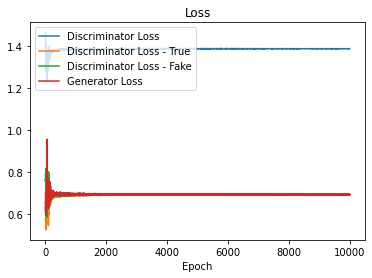

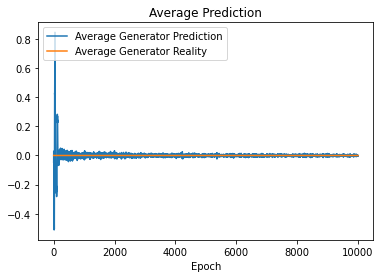

In [220]:
plotting.plot_training_curve(d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true, fig_dir, exp_config.run.save_fig)

In [221]:
ypred_gp_val = y_scaler.inverse_transform(ypred_gp_val)
ypred_reg_cgan_val = y_scaler.inverse_transform(ypred_reg_cgan_val)

## Marginalized distribution

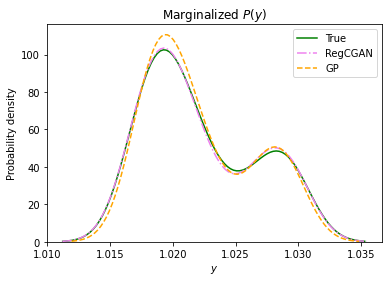

In [222]:
plotting.plot_densities_joint(y_valid, ypred_reg_cgan_val, ypred_gp_val,
                             title=f"Marginalized $P(y)$", fig_dir=fig_dir,
                             prefix="marginalized_P(y)", save_fig=exp_config.run.save_fig)

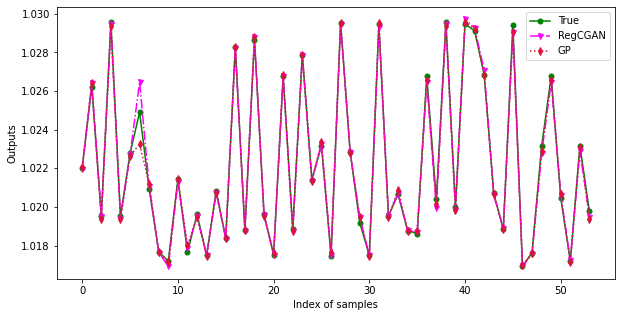

In [217]:
plotting.plot_ypred(y_valid, ypred_reg_cgan_val, ypred_gp_val,
                          fig_dir=fig_dir, prefix="regcgan_gp", save_fig=exp_config.run.save_fig)

## Metrics on validation samples

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

reg_cgan_mae_list = []
reg_cgan_mse_list = []

gp_mae_list = []
gp_mse_list =[]

n_eval_runs = 50
for i in range(n_eval_runs):
    ypred_reg_cgan= regcgan.predict(X_valid_scaled)
    reg_cgan_mae_list.append(mean_absolute_error(y_valid, y_scaler.inverse_transform(ypred_reg_cgan)))
    reg_cgan_mse_list.append(mean_squared_error(y_valid, y_scaler.inverse_transform(ypred_reg_cgan)))

    y_pred_gp, cov = gpr.predict(X_valid_scaled)
    yped_gp = np.random.normal(y_pred_gp, np.sqrt(cov))
    gp_mae_list.append(mean_absolute_error(y_valid, y_scaler.inverse_transform(yped_gp)))
    gp_mse_list.append(mean_squared_error(y_valid, y_scaler.inverse_transform(yped_gp)))

In [40]:
reg_cgan_mae_mean, reg_cgan_mae_std = np.mean(np.asarray(reg_cgan_mae_list)), np.std(np.asarray(reg_cgan_mae_list))
reg_cgan_mse_mean, reg_cgan_mse_std = np.mean(np.asarray(reg_cgan_mse_list)), np.std(np.asarray(reg_cgan_mse_list))

print(f"MAE for RegCGAN: {reg_cgan_mae_mean:.3e} +- {reg_cgan_mae_std:.5e}")
print(f"MSE for RegCGAN: {reg_cgan_mse_mean:.3e} +- {reg_cgan_mse_std:.5e}")

gp_mae_mean, gp_mae_std = np.mean(np.asarray(gp_mae_list)), np.std(np.asarray(gp_mae_list))
gp_mse_mean, gp_mse_std = np.mean(np.asarray(gp_mse_list)), np.std(np.asarray(gp_mse_list))
print(f"MAE for GP: {gp_mae_mean:.3e} +- {gp_mae_std:.5e}")
print(f"MAE for GP: {gp_mse_mean:.3e} +- {gp_mse_std:.5e}")

Validation MAE for RegCGAN: 1.546e-04 +- 7.18953e-07
Validation MSE for RegCGAN: 7.306e-08 +- 1.10946e-09
Validation MAE for GP: 4.717e-03 +- 4.66884e-04
Validation MAE for GP: 3.375e-05 +- 6.56562e-06


In [41]:
nlpd_list = []
for i in range(n_eval_runs):
    y_pred_gp, cov = gpr.predict(X_valid_scaled)
    nlpd_list.append(metrics.gaussian_NLPD(y_valid,
                                           np.random.normal(y_scaler.inverse_transform(ypred_gp_val), np.sqrt(cov)),
                                           cov))
gp_nlpd_mean = np.mean(nlpd_list)
gp_nlpd_std = np.std(nlpd_list)
print(f"NLPD for GP: {gp_nlpd_mean:.3f} +- {gp_nlpd_std:.5f}")

NLPD for GP: 1.420 +- 0.08602


In [73]:
_, w, _ = metrics.Parzen(regcgan, X_valid_scaled, y_valid_scaled)
nlpd_list = []
for i in range(n_eval_runs):
    nlpd_list.append(metrics.Parzen_test(regcgan, X_valid_scaled, y_valid_scaled, 0.01, exp_config.training.n_sampling))
reg_cgan_nlpd_mean = np.mean(nlpd_list)
reg_cgan_nlpd_std = np.std(nlpd_list)
print(f"NLPD for RegCGAN: {reg_cgan_nlpd_mean:.3f} +- {reg_cgan_nlpd_std:.5f}")

NLPD for RegCGAN: 2.257 +- 0.92077


In [74]:
if exp_config.run.save_fig:

    try:
        file = open(f"{fig_dir}/metrics_on_validation_samples.txt","w")
    except FileExistsError:
        print(f" {fig_dir} was failed to create.")

    file.write(f"===MAE===\n")
    file.write(f"MAE for GP: {gp_mae_mean} +- {gp_mae_std}\n")
    file.write(f"MAE for GP RegCGAN: {reg_cgan_mae_mean} +- {reg_cgan_mae_std}\n")
    file.write(f"===MSE===\n")
    file.write(f"MSE for GP: {gp_mse_mean} +- {gp_mse_std}\n")
    file.write(f"MSE for RegCGAN: {reg_cgan_mse_mean} +- {reg_cgan_mse_std}\n")
    file.write(f"===NLPD===\n")
    file.write(f"NLPD for GP: {gp_nlpd_mean} +- {gp_nlpd_std}\n")
    file.write(f"NLPD for RegCGAN: {reg_cgan_nlpd_mean} +- {reg_cgan_nlpd_std}\n")
    file.close()
